In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re
import cdtime
import glob


pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def rescale (F, factor=None, myunits=None, offset=None):
    name = F.id
    if ((not offset is None) & (not factor is None)):
        print("rescale cannot set both offset and factor")
        # if you want to then exit the program
        import sys
        sys.exit(1)
    if not offset is None:
        F = F - offset;
    if not factor is None:
        F = F*Factor
    if not myunits is None:
        F.units = myunits 
    if F.id is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if F.id is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "BURDEN2":
        F = F*1.e6
        F.units = "mg/m2"
        
    F.id = name
    return F;

# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None, time=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1, time=time)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
import matplotlib.path as mpath
def setup3 ():
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    sbnd = 60.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(figsize=(4, 8)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[10, 1]) 

    ax0 = plt.subplot(gs[0],projection=ccrs.NorthPolarStereo())
    ax0.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax0.set_boundary(circle, transform=ax0.transAxes)
#   ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    
    ax1 = plt.subplot(gs[2],projection=ccrs.NorthPolarStereo())
    ax1.set_global() # make axis consistent with projection limits
    ax1.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.NorthPolarStereo())
    ax2.set_global() # make axis consistent with projection limits
    ax2.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Orthographic(0, 90))
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, fig=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
#    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
#    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
#   print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
#    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, fig, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


In [4]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

#vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
#vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

#vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
vlist.append(vsets("TMQ", "TMQ","TMQ"))
#vlist.append(vsets("SST", "SST","SST"))
#vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
#vlist.append(vsets("FLNT", "FLNT","FLNT"))
#vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
#vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
#vlist.append(vsets('LWCF', 'LWCF','LWCF'))
#vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
#vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
#vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets('SWCF', 'SWCF','SWCF'))
#vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
#vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
#vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
#vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))


def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["JAN"]

In [5]:
# identify fields to be evaluated


def setupfilenames (mon):
    import fnmatch
    import os
    # model2 dataset (the experiment)
    dir2 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir2 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    files = fnmatch.filter(os.listdir(dir2), "*cam.h1.2009-"+mon+"*00.nc")
#    print "files", files
    
    # the "reference" dataset
    dir1 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir1 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    f1 = "yotc_f02_pdil_sat_"+mon+".cam.h0.2009-"+mon+".nc"

    
#   print "all",files
#    files = files

#    for f2 in files:
#        #print "f2 is ", f2
#        print(f2)
    
    return dir1, f1, dir2, files



In [6]:

def processtime(vname, dir1, f1, dir2, files):
    
    print "processing time average"
# model1 dataset (the reference)

    title1 = "MONAVG"
    ltit1 = title1  
    rtit1 = ""
    jname1 = dir1+f1
    print "jname1 ", jname1    

    g1 = cdms2.open(jname1);
    print "reference dataset is jname1", jname1  

#    varlist2 = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist2
#    dims2 = g2.listdimension();
#    print "g2 dims", dims2    
    

    T1 = getfld(g1,vname,time=slice(0,1)) # first time slice
    T1 = rescale(T1);
#    print "T1 shape", T1.shape

    print "processing timeslice from dir2 ", dir2
    for f2 in files:

        # model2 dataset (the experiment) 
        jname2 = dir2+f2
        g2 = cdms2.open(jname2);
        print "jname2", jname2
        varlist = g2.listvariables();
    #   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
    #    print "g2 varlist", varlist
        dims = g2.listdimension();
    #   print "j2 dims"
        dims = g2.listdimension();
        tindex = dims.index('time')
    #   print "tindex", tindex
        diminfo = g2[dims[tindex]].attributes
        #xx = g2[dims[tindex]].asComponentTime()
        #print "xx",xx
    #    print "diminfo", diminfo
        timeunits = diminfo['units']
        #print "timeunits", timeunits
        times = g2[dims[tindex]][:]
        #print "times", times
        starttime = g2[dims[tindex]][0]
        #print "starttime", starttime

    #if 1 == 1:
        thistime = times[0]
    #for thistime in times:
        #print "thistime", thistime

        #T2 = getfld(g2,vname,time=slice(0,1))
        T2 = getfld(g2,vname,time=thistime)
        T2 = rescale(T2)
        rt = cdtime.reltime(thistime, timeunits)
        #print "rt", rt
        ct = rt.tocomp()
        #help(ct)
        #print "ct", ct

        title2 = "{:.2f}".format(thistime)
        title2 = ct
        ltit2 = title2
        rtit2 = ""

    # if 1 == 1:
        sbnd = 60.
        T1 = T1.subRegion(latitude=(sbnd,90.))
        T2 = T2.subRegion(latitude=(sbnd,90.))


    #    T2 = getfld(g2,"QV")
    #    DELP = getfld(g2,'DELP')
    #    T2V = T2*DELP/9.806

    #    T2V = cdutil.averager(T2V,axis="t",weights='unweighted')
    #    T2V = cdutil.averager(T2V,axis="z",weights='equal', action='sum')
    #    print "range", T2V.min(), T2V.max()
    #    pltframe(T2V, lons, lats, ax3[0], cx3[0])    
    #    T2 = T2V    

        if plottype == "DIFF":
            DT = T2 - T1
        else:
            DT = T2/T1
            DT.units = "Ratio"

        DT.id = T1.id

        ctstring = "{:04d}_{:02d}_{:02d}h{:02d}".format(ct.year, ct.month, ct.day, ct.hour)
        if plottype == "DIFF":
            pltname = "workdir/"+vname+"_"+ctstring+"_D.pdf"
        else:
            pltname = "workdir/"+vname+"_"+ctstring+"_R.pdf"

        lons = T1.getLongitude()
        lats = T1.getLatitude()
    #   pltframe(T1, lons, lats, ax3[1], cx3[1])# , 
        #plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

        print "figure being saved to ", pltname
        fig, ax3, cx3 = setup3()
    #    pltframe(DT, lons, lats, ax3[2], cx3[2]) #, 
        #  plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})    

        cmap = plt.cm.viridis

    #    print "plotting MERRA2"
    #    print TP0.info()
        dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
        clevs = pjr.findNiceContours(dtrng)
        if T1.id == "BURDEN2":
            clevs = np.array([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])*0.1

        pltframe(T2, lons, lats, fig, ax3[0], cx3[0], 
                 plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    #    print "plotting E3SM"
        pltframe(T1, lons, lats, fig, ax3[1], cx3[1], 
                 plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

        cmap = pjr.diverge_map()
    #   cmap = plt.cm.viridis


    #    print "T1.info", T1.info()
    #    print "DT info", DT.info()

    #    print "DT.id", DT.id
        if plottype == "DIFF":
            dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
            if DT.id == 'LWCF':
                dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
            if DT.id == 'SWCF':
                dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
            if DT.id == 'TS':
                dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
            if DT.id == 'TGCLDIWP':
                dlevs = [-5.,-2.,-1.,1.,2.,5.]
            if DT.id == 'FSNT':
                dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
            if DT.id == 'BURDEN1':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])
            if DT.id == 'BURDEN2':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])

        else:
            # ratio plots
            dtrng = np.array([0.,DT.max()])
            print "dtrng", dtrng
            dtrng = dtrng*0.5
            dlevs = pjr.findNiceContours(dtrng,nlevs=12,rmClev=0, sym=True)
            print "dlevs1", dlevs
            dlevs = (dlevs + dlevs.max())
            if DT.id == 'BURDEN1':
                dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
            if DT.id == 'BURDEN2':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
            if DT.id == 'TMQ':
                dlevs = np.array([0.,0.2,0.4,0.6,0.8,1.2,1.5,2.,3.0,4.0])
                print "final ratio plot dlevs", dlevs

        dtitle = ""
        rtitD = vname
        pltframe(DT, lons, lats, fig, ax3[2], cx3[2], 
                 plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        x = plt.show()

        print "done with time "+ctstring+"\n\n\n"
      
    print "processtime complete"
    return



processing time average
jname1  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h0.2009-01.nc
reference dataset is jname1 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h0.2009-01.nc
processing timeslice from dir2  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/
jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-18-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_18h06_D.pdf
data range 0.021297373 0.22869772
data range 0.037203263 0.10387778
data range -0.049701184 0.14219195


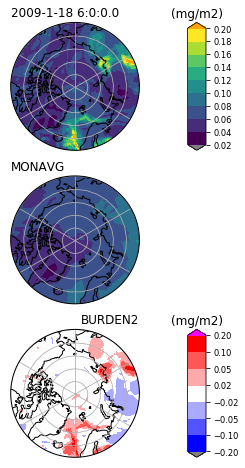

done with time 2009_01_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-12-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_12h06_D.pdf
data range 0.036151588 0.20940208
data range 0.037203263 0.10387778
data range -0.039393965 0.12568635


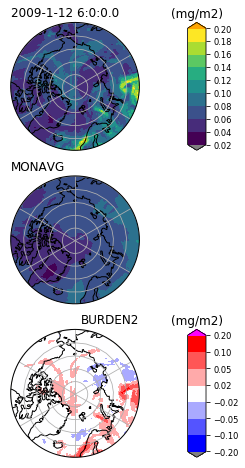

done with time 2009_01_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-06-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_06h06_D.pdf
data range 0.021059915 0.20549718
data range 0.037203263 0.10387778
data range -0.06074829 0.11853577


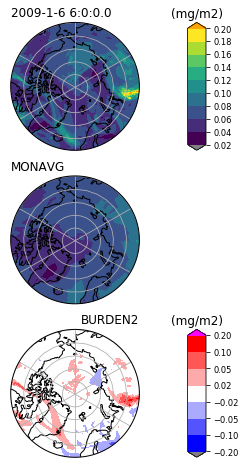

done with time 2009_01_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-11-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_11h06_D.pdf
data range 0.03228048 0.28674784
data range 0.037203263 0.10387778
data range -0.047372464 0.19277266


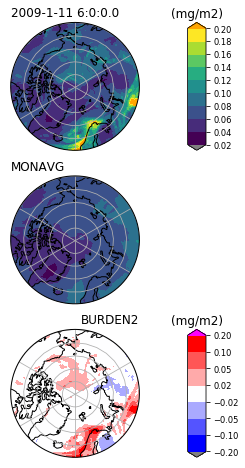

done with time 2009_01_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-09-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_09h06_D.pdf
data range 0.028224684 0.2625136
data range 0.037203263 0.10387778
data range -0.04366768 0.17592707


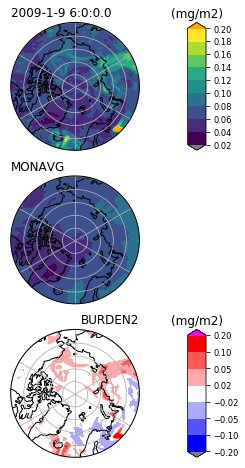

done with time 2009_01_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-29-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_29h06_D.pdf
data range 0.019221585 0.21850212
data range 0.037203263 0.10387778
data range -0.044173762 0.1358416


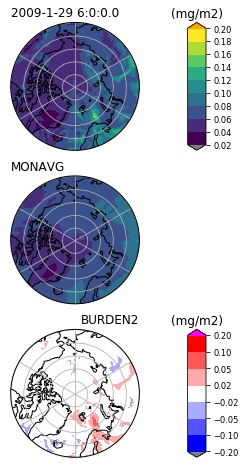

done with time 2009_01_29h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-07-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_07h06_D.pdf
data range 0.024229368 0.2184379
data range 0.037203263 0.10387778
data range -0.04763458 0.14350371


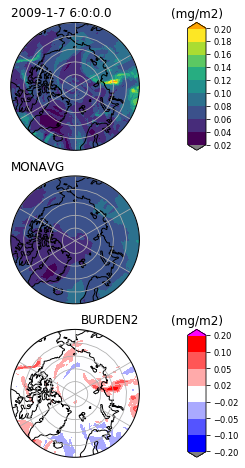

done with time 2009_01_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-03-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_03h06_D.pdf
data range 0.023144128 0.20446016
data range 0.037203263 0.10387778
data range -0.048135612 0.11448521


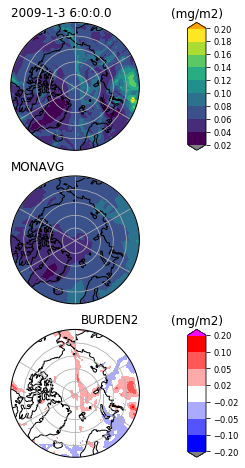

done with time 2009_01_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-02-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_02h06_D.pdf
data range 0.023147143 0.16960157
data range 0.037203263 0.10387778
data range -0.065892614 0.08128403


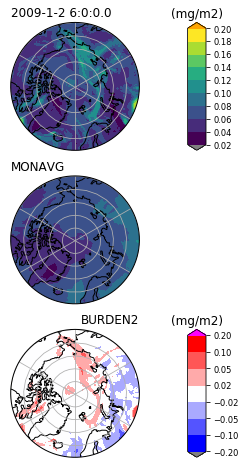

done with time 2009_01_02h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-05-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_05h06_D.pdf
data range 0.02964271 0.16613124
data range 0.037203263 0.10387778
data range -0.053504515 0.09350085


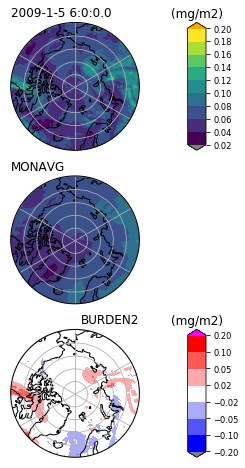

done with time 2009_01_05h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-08-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_08h06_D.pdf
data range 0.027242746 0.19456682
data range 0.037203263 0.10387778
data range -0.047972325 0.10107533


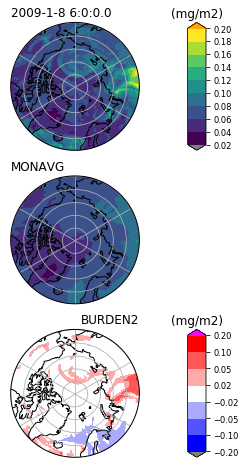

done with time 2009_01_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-21-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_21h06_D.pdf
data range 0.022639139 0.17937829
data range 0.037203263 0.10387778
data range -0.059978597 0.09379992


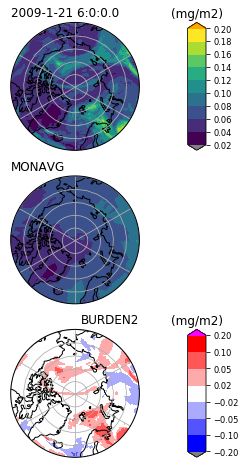

done with time 2009_01_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-15-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_15h06_D.pdf
data range 0.018207245 0.18625583
data range 0.037203263 0.10387778
data range -0.046701208 0.11528141


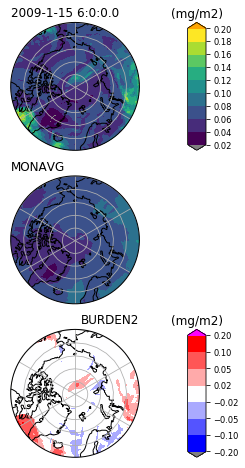

done with time 2009_01_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-28-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_28h06_D.pdf
data range 0.023087492 0.19774997
data range 0.037203263 0.10387778
data range -0.040825754 0.10395682


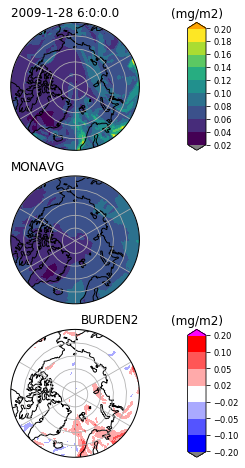

done with time 2009_01_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-30-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_30h06_D.pdf
data range 0.023293216 0.2612214
data range 0.037203263 0.10387778
data range -0.04526755 0.17434314


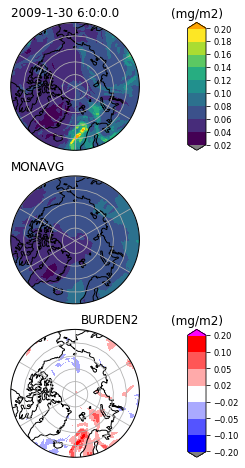

done with time 2009_01_30h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-22-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_22h06_D.pdf
data range 0.023186503 0.2046442
data range 0.037203263 0.10387778
data range -0.052659668 0.119414434


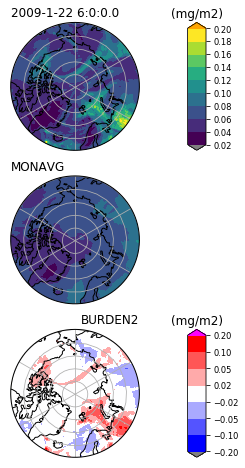

done with time 2009_01_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-31-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_31h06_D.pdf
data range 0.025723666 0.19283202
data range 0.037203263 0.10387778
data range -0.055404473 0.11129966


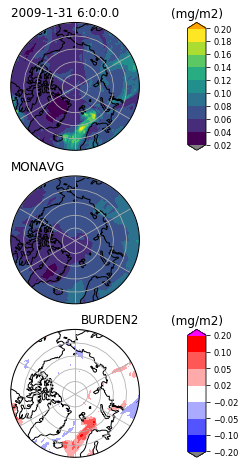

done with time 2009_01_31h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-19-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_19h06_D.pdf
data range 0.028774446 0.20453107
data range 0.037203263 0.10387778
data range -0.06659723 0.12886715


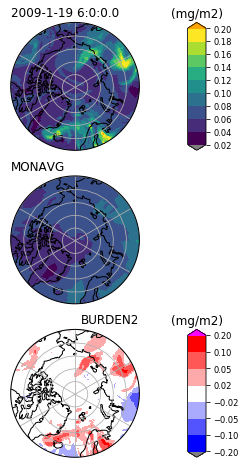

done with time 2009_01_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-23-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_23h06_D.pdf
data range 0.027393157 0.27017105
data range 0.037203263 0.10387778
data range -0.05072424 0.19596988


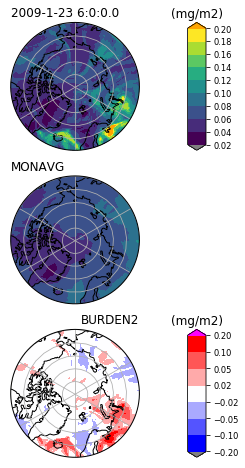

done with time 2009_01_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-25-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_25h06_D.pdf
data range 0.027830182 0.3663962
data range 0.037203263 0.10387778
data range -0.052041728 0.27228194


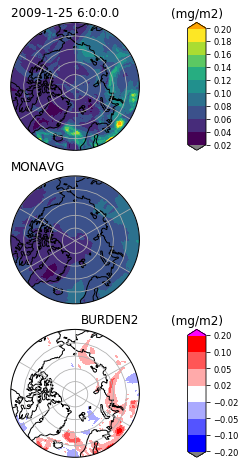

done with time 2009_01_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-16-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_16h06_D.pdf
data range 0.026352676 0.2582867
data range 0.037203263 0.10387778
data range -0.039544456 0.16442397


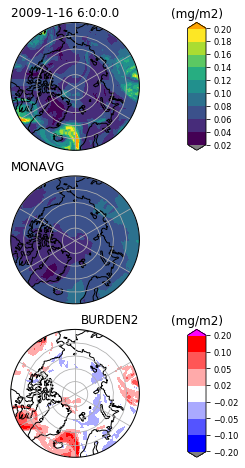

done with time 2009_01_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-27-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_27h06_D.pdf
data range 0.030354336 0.25994012
data range 0.037203263 0.10387778
data range -0.03032966 0.17272854


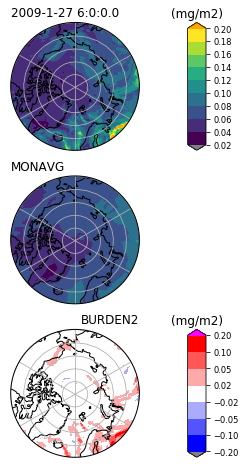

done with time 2009_01_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-01-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_01h06_D.pdf
data range 0.020614652 0.2622628
data range 0.037203263 0.10387778
data range -0.061711363 0.19571239


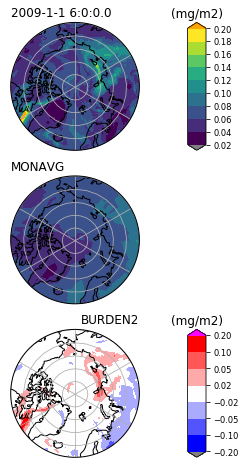

done with time 2009_01_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-17-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_17h06_D.pdf
data range 0.027856324 0.26634234
data range 0.037203263 0.10387778
data range -0.048607897 0.18736434


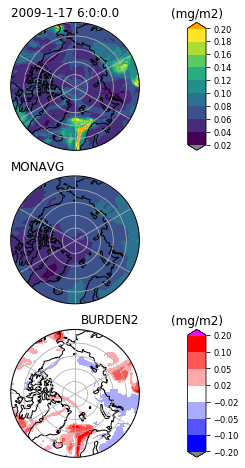

done with time 2009_01_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-14-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_14h06_D.pdf
data range 0.029367942 0.19173302
data range 0.037203263 0.10387778
data range -0.040321406 0.09985102


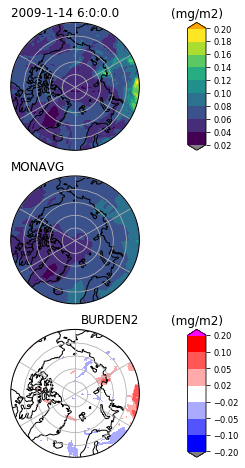

done with time 2009_01_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-20-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_20h06_D.pdf
data range 0.02230222 0.18541752
data range 0.037203263 0.10387778
data range -0.051367134 0.105177395


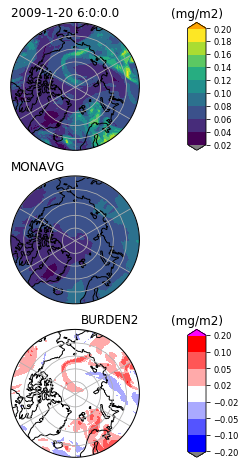

done with time 2009_01_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-24-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_24h06_D.pdf
data range 0.026563665 0.21472092
data range 0.037203263 0.10387778
data range -0.045860477 0.13933048


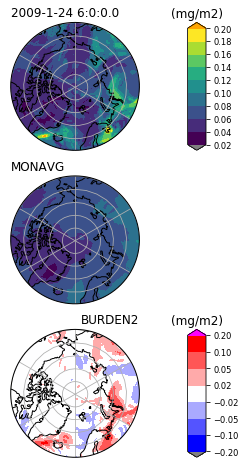

done with time 2009_01_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-10-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_10h06_D.pdf
data range 0.027990518 0.25968176
data range 0.037203263 0.10387778
data range -0.043938026 0.18442203


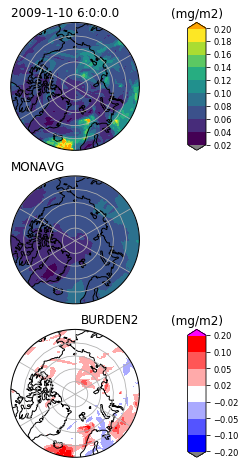

done with time 2009_01_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-04-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_04h06_D.pdf
data range 0.026085183 0.1470853
data range 0.037203263 0.10387778
data range -0.047352742 0.07305322


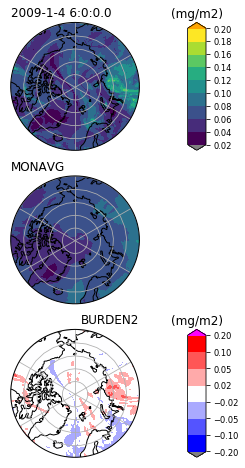

done with time 2009_01_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-26-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_26h06_D.pdf
data range 0.032175902 0.26198047
data range 0.037203263 0.10387778
data range -0.045377992 0.16185194


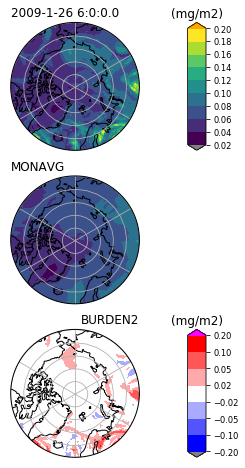

done with time 2009_01_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-13-21600.nc
figure being saved to  workdir/BURDEN2_2009_01_13h06_D.pdf
data range 0.028107405 0.20214927
data range 0.037203263 0.10387778
data range -0.04853426 0.115241215


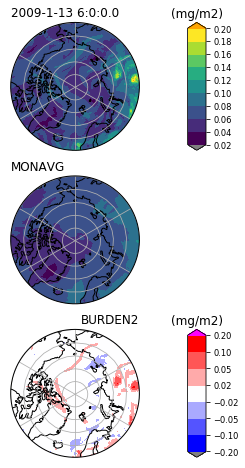

done with time 2009_01_13h06



processtime complete
all done


In [8]:
monlist = np.array(["01","02","03","04"])
monlist = np.array(["01"])
for mon in monlist:
    dir1, f1, dir2, files = setupfilenames(mon)



    vname = "TMQ"
    plottype = "RATIO"
    
    vname = "BURDEN1"
    vname = "BURDEN2"
    
    plottype = "RATIO"
    plottype = "DIFF"
    dfact = 0.5  # multiplier on contour levels for difference anomalies
    dfact = 1.0  


    #files = {files[0]} # select only the first file for debugging   
    processtime (vname, dir1, f1, dir2, files)
print "all done"